In [45]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
tf.compat.v1.disable_eager_execution()
sns.set()
Candledf=pd.read_csv('../result.dat',low_memory=False)
Candledf['ndatetime']=pd.to_datetime(Candledf['ndatetime'],format='%Y-%m-%d %H:%M:%S.%f')
print(Candledf.tail())

                ndatetime   open   high    low  close  volume
10037 2021-10-29 11:24:05  16943  16958  16936  16957   12000
10038 2021-10-29 12:00:00  16956  16976  16943  16960   12000
10039 2021-10-29 12:30:05  16960  16965  16938  16944   12000
10040 2021-10-29 13:11:58  16944  16965  16940  16945   12000
10041 2021-10-29 13:35:42  16946  16958  16943  16945    6758


In [46]:
from collections import deque
import random

In [47]:
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.compat.v1.reset_default_graph()
        self.sess = tf.compat.v1.InteractiveSession()
        self.X = tf.compat.v1.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.compat.v1.placeholder(tf.float32, [None, self.action_size])
        feed = tf.compat.v1.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.compat.v1.layers.dense(feed, self.action_size)
        self.cost = tf.compat.v1.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.compat.v1.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        init = tf.compat.v1.global_variables_initializer()
        self.sess.run(init)

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost, starting_money))

In [48]:
close = Candledf.close.to_list()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = 30, window_size = 30,trend = close,  skip = skip, batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

C:\Users\Owner\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\client\session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\Owner\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\Owner\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


epoch: 10, total rewards: 1538.000000.3, cost: 0.544140, total money: 11538.000000
epoch: 20, total rewards: 950.000000.3, cost: 0.142383, total money: 10950.000000
epoch: 30, total rewards: 668.000000.3, cost: 0.052679, total money: 10668.000000
epoch: 40, total rewards: -124.000000.3, cost: 0.164914, total money: 9876.000000
epoch: 50, total rewards: 301.000000.3, cost: 0.006335, total money: 10301.000000
epoch: 60, total rewards: -416.000000.3, cost: 0.002215, total money: 9584.000000
epoch: 70, total rewards: 181.000000.3, cost: 0.011088, total money: 10181.000000
epoch: 80, total rewards: -64.000000.3, cost: 0.039492, total money: 9936.000000
epoch: 90, total rewards: -21.000000.3, cost: 0.004168, total money: 9979.000000
epoch: 100, total rewards: 221.000000.3, cost: 0.010318, total money: 10221.000000
epoch: 110, total rewards: -171.000000.3, cost: 0.001155, total money: 9829.000000
epoch: 120, total rewards: 452.000000.3, cost: 0.008326, total money: 10452.000000
epoch: 130, to

In [49]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 3608: buy 1 unit at price 8334.000000, total balance 1666.000000
day 3609, sell 1 unit at price 8325.000000, investment -0.107991 %, total balance 9991.000000,
day 3671: buy 1 unit at price 9077.000000, total balance 914.000000
day 3672, sell 1 unit at price 9017.000000, investment -0.661011 %, total balance 9931.000000,
day 3699: buy 1 unit at price 8811.000000, total balance 1120.000000
day 3700, sell 1 unit at price 9183.000000, investment 4.221995 %, total balance 10303.000000,
day 3762: buy 1 unit at price 9638.000000, total balance 665.000000
day 3763, sell 1 unit at price 9547.000000, investment -0.944179 %, total balance 10212.000000,
day 3775: buy 1 unit at price 9826.000000, total balance 386.000000
day 3776, sell 1 unit at price 9755.000000, investment -0.722573 %, total balance 10141.000000,
day 3785: buy 1 unit at price 9580.000000, total balance 561.000000
day 3786, sell 1 unit at price 9599.000000, investment 0.198330 %, total balance 10160.000000,
day 3864: buy 1 un

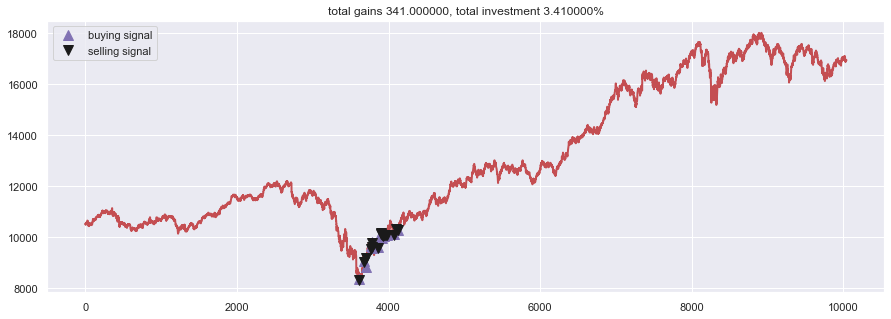

In [50]:

fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()